In [2]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from torch.optim import Adam, lr_scheduler

from Experiments import get_setup


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
dataset='boston'

In [5]:
setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

X_train, y_train=setup.train_data()
X_test, y_test=setup.test_data()

model=setup._model
input_dim=X_train.shape[1]
param_count=setup.param_count

In [6]:
#generative model
from Models import BigGenerator

lat_dim=5
GeN = BigGenerator(lat_dim,param_count,device).to(device)


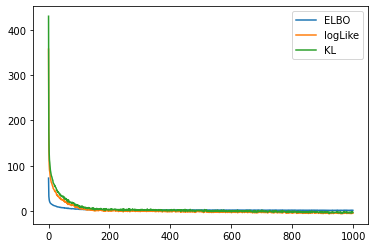

In [7]:
training=torch.load('Results/'+dataset+'_2020-07-18-11:19_training.pt')
ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
plt.plot(torch.arange(0,len(training['KL']),1),ELBO_, label='ELBO')
plt.plot(torch.arange(0,len(training['KL']),1),KL_-ELBO_, label='logLike')
plt.plot(torch.arange(0,len(training['KL']),1),KL_, label='KL')
plt.legend()

In [9]:
state_dict=torch.load('mlruns/2/c40e5719924a44a2a88260bb8eb63c6f/artifacts/FuNmodels.pt')


In [10]:
HMC_models=torch.load('Results/HMC_models.pt')


In [13]:
GeN.load_state_dict(state_dict[dataset]['0'])


<All keys matched successfully>

In [14]:
sigma_prior=setup.sigma_prior

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


In [15]:
def KL(theta0, theta1, k=1, device='cpu', p=2):
    """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions
            theta1 (Tensor): Samples, R X NbDimensions
            k (Int): positive ordinal number

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """

    n0 = theta0.shape[0]
    n1 = theta1.shape[0]
    dim0 = theta0.shape[1]
    dim1 = theta1.shape[1]
    assert dim0 == dim1

    D0 = torch.cdist(theta0, theta0, p=p)
    D1 = torch.cdist(theta0, theta1, p=p)
    D2 = torch.cdist(theta1, theta1, p=p)

    a0 = torch.topk(D0, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k - 1]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a2 = torch.topk(D2, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)

    assert a0.shape == a1.shape

    d = torch.as_tensor(float(dim0), device=device)
    N0 = torch.as_tensor(float(n0), device=device)
    N1 = torch.as_tensor(float(n1), device=device)

    Mnn = (torch.log(a1) - torch.log(a0)).mean()
    return d * Mnn + N1.log() - (N0 - 1).log(), a0, a1, a2

In [16]:
n_samples_FU=200
def projection(theta0,theta1):
    #batch sample OOD   
    n_ood=n_samples_FU
    epsilon=0.1
    M = X_train.max(0, keepdim=True)[0]+epsilon
    m = X_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=X_ood

    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

In [20]:
n_samples_KL=500
theta0=GeN(n_samples_KL).detach()
theta1=prior(n_samples_KL).to(device)

In [22]:
HMC=HMC_models[dataset][:n_samples_KL].to(device)
pred0, pred1=projection(HMC,theta1)

K, a_0, a_1, a_2= KL(pred0,pred1)

In [23]:
X=torch.arange(0,n_samples_KL,1)

57.384647369384766


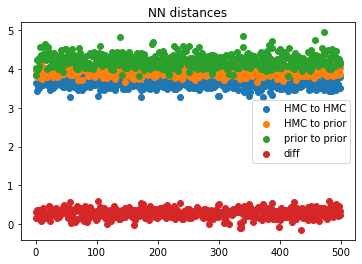

In [24]:
plt.scatter(X,a_0.log().cpu(), label='HMC to HMC')
plt.scatter(X,a_1.log().cpu(), label='HMC to prior')
plt.scatter(X,a_2.log().cpu(), label='prior to prior')
plt.title('NN distances')
plt.scatter(X,(a_1.log()-a_0.log()).cpu(), label='diff')
plt.legend()
print(K.item())

In [25]:
pred0, pred1=projection(theta0,theta1)

K, a_0, a_1, a_2= KL(pred0,pred1)

In [26]:
a_0_s, _=a_0.sort()
a_1_s, _=a_1.sort()

-44.741424560546875


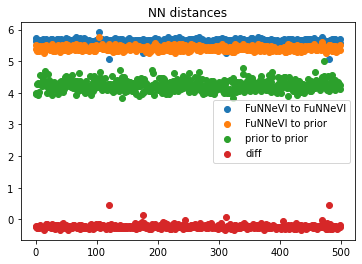

In [27]:
plt.scatter(X,a_0.log().cpu(), label='FuNNeVI to FuNNeVI')
plt.scatter(X,a_1.log().cpu(), label='FuNNeVI to prior')
plt.scatter(X,a_2.log().cpu(), label='prior to prior')
plt.title('NN distances')
plt.scatter(X,(a_1.log()-a_0.log()).cpu(), label='diff')
plt.legend()
print(K.item())

In [41]:
X_train_=X_train[:500]
theta0_train=model(X_train_, theta0).squeeze(2).cpu()
theta1_train=model(X_train_, theta1).squeeze(2).cpu()
HMC_train=model(X_train_, HMC).squeeze(2).cpu()

In [42]:
theta_all=torch.cat([theta0_train.cpu(),theta1_train.cpu(), HMC_train.cpu()],dim=0)


In [43]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=50)
X_embedded_p =myTSNE.fit_transform(theta_all.cpu())
print(myTSNE.kl_divergence_)
X_embedded_p.shape

1.513293981552124


(1500, 2)

In [44]:
theta_all_c=[0.]*n_samples_KL+[1.]*n_samples_KL+[2.]*n_samples_KL

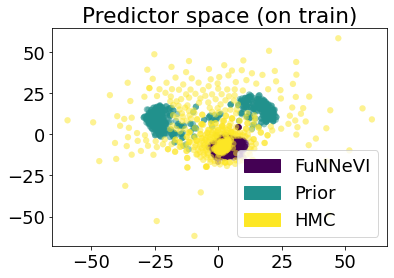

In [45]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})
import matplotlib.cm as cm

cmap = cm.viridis


plt.scatter(X_embedded_p[:,0],X_embedded_p[:,1],c=theta_all_c, linewidth=0.2, alpha=0.5, cmap=cmap)
plt.title('Predictor space (on train)')

patch0 = mpatches.Patch(color=cmap(0.), label='FuNNeVI')
patch1 = mpatches.Patch(color=cmap(.5), label='Prior')
patch2 = mpatches.Patch(color=cmap(1.), label='HMC')

plt.legend(handles=[patch0,patch1, patch2])

plt.show()


In [46]:
n_ood=n_samples_FU
epsilon=0.1
M = X_train.max(0, keepdim=True)[0]+epsilon
m = X_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

X=X_ood

#compute projection on both paramters with model
theta0_proj=model(X, theta0).squeeze(2)
theta1_proj=model(X, theta1).squeeze(2)
HMC_proj=model(X, HMC).squeeze(2)

In [47]:
theta_all=torch.cat([theta0_proj.cpu(),theta1_proj.cpu(), HMC_proj.cpu()],dim=0)


In [48]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=50)
X_embedded_p =myTSNE.fit_transform(theta_all.cpu())
print(myTSNE.kl_divergence_)
X_embedded_p.shape

1.3999230861663818


(1500, 2)

In [49]:
theta_all_c=[0.]*n_samples_KL+[1.]*n_samples_KL+[2.]*n_samples_KL

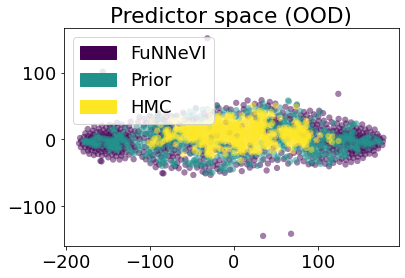

In [50]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})
import matplotlib.cm as cm

cmap = cm.viridis


plt.scatter(X_embedded_p[:,0],X_embedded_p[:,1],c=theta_all_c, linewidth=0.2, alpha=0.5, cmap=cmap)
plt.title('Predictor space (OOD)')

patch0 = mpatches.Patch(color=cmap(0.), label='FuNNeVI')
patch1 = mpatches.Patch(color=cmap(.5), label='Prior')
patch2 = mpatches.Patch(color=cmap(1.), label='HMC')

plt.legend(handles=[patch0,patch1, patch2])

plt.show()
